# This notebook includes #
- information on how we extracted the INE database from SQL
- analyses on the agricultural activity totals and averages
- analysess on the temporal trends of the the agricultural activies

### An analysis on how agricultural practices have changed over time and how these changes are related to socio-economic factors ###

### First, data wrangling and extraction... ###

This data was first uploaded from our INE database, organized, and then converted to a csv file for simpler sharing of the files.

The data contains information from the years 1989, 1999, 2009 and 2019 on the education levels and value, labor type and value, production value (in euros) and production area (in ha), livestock type and counts, temporary crop type, counts and area, permanent crop type, counts (in number of holdings), and area, and permanent crop type, counts (in number of holdings), and area. All of the rows of data are organized by freguesia name. 

In [2]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import mysql.connector
import pandas as pd

# Database connection parameters
db_params = {
    'host': 'localhost',
    'database': 'dms_INE',
    'user': 'Ines',
    'password': 'aa4862aa'
}

# Connect to the database
conn = mysql.connector.connect(
    host=db_params['host'],
    database=db_params['database'],
    user=db_params['user'],
    password=db_params['password']
)

# SQL queries
sql_query_education_labour = """
SELECT
    r.NutsID,
    RIGHT(r.NutsID, 6) AS DICOFRE,
    r.region_name AS freguesia,
    e.year AS education_year,
    el.education_level,
    e.value AS education_value,
    tl.type_labour,
    l.value AS labour_value,
    p.value_eur AS production_value_eur,
    p.area_ha AS production_area_ha
FROM
    education e
INNER JOIN region r ON e.NutsID = r.NutsID
INNER JOIN region_level rl ON r.level_ID = rl.level_ID
INNER JOIN education_level el ON e.education_level_ID = el.education_level_ID
INNER JOIN labour l ON e.NutsID = l.NutsID AND e.year = l.year
INNER JOIN type_labour tl ON l.type_labour_ID = tl.type_labour_ID
LEFT JOIN production p ON e.NutsID = p.NutsID AND e.year = p.year
WHERE
    rl.region_level = 'freguesia'
    AND r.NutsID NOT LIKE '200%'  -- Exclude Madeira
    AND r.NutsID NOT LIKE '300%'  -- Exclude Azores
    AND el.education_level <> 'Total';
"""

sql_query_agriculture = """
SELECT
    r.NutsID,
    RIGHT(r.NutsID, 6) AS DICOFRE,
    r.region_name AS freguesia,
    tc.year AS temporary_crop_year,
    tc.area AS temporary_crop_area,
    tc.hold AS temporary_crop_holdings,
    tcn.crop_name AS temporary_crop_name,
    pc.year AS permanent_crop_year,
    pc.area AS permanent_crop_area,
    pc.hold AS permanent_crop_holdings,
    pcn.crop_name AS permanent_crop_name
FROM
    grassland g
INNER JOIN region r ON g.NutsID = r.NutsID
INNER JOIN region_level rl ON r.level_ID = rl.level_ID
INNER JOIN livestock l2 ON g.NutsID = l2.NutsID AND g.year = l2.year
INNER JOIN livestock_name ln2 ON l2.livestock_name_ID = ln2.livestock_name_ID
INNER JOIN temporary_crop tc ON g.NutsID = tc.NutsID AND g.year = tc.year
INNER JOIN temporary_crop_name tcn ON tc.tc_name_ID = tcn.tc_name_ID
INNER JOIN permanent_crop pc ON g.NutsID = pc.NutsID AND g.year = pc.year
INNER JOIN permanent_crop_name pcn ON pc.pc_name_ID = pcn.pc_name_ID
WHERE
    rl.region_level = 'freguesia'
    AND r.NutsID NOT LIKE '200%'  -- Exclude Madeira
    AND r.NutsID NOT LIKE '300%'  -- Exclude Azores
    AND tcn.crop_name NOT LIKE 'Total'
    AND pcn.crop_name NOT LIKE 'Total';
"""

# Execute the queries and load the data into DataFrames
df_education_labour = pd.read_sql(sql_query_education_labour, conn)
df_agriculture = pd.read_sql(sql_query_agriculture, conn)

# Close the database connection
conn.close()

# Display the first few rows of each DataFrame
print(df_education_labour.head())
print(df_agriculture.head())


/var/folders/nx/dr_pnkkn1yg156jk80s020sc0000gn/T/ipykernel_1529/1109415096.py:80: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_education_labour = pd.read_sql(sql_query_education_labour, conn)
/var/folders/nx/dr_pnkkn1yg156jk80s020sc0000gn/T/ipykernel_1529/1109415096.py:81: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_agriculture = pd.read_sql(sql_query_agriculture, conn)


      NutsID DICOFRE         freguesia  education_year  \
0  111160101  160101  Aboim das Choças            1989   
1  111160101  160101  Aboim das Choças            1989   
2  111160101  160101  Aboim das Choças            1989   
3  111160101  160101  Aboim das Choças            1989   
4  111160101  160101  Aboim das Choças            1999   

              education_level  education_value  \
0                        None              167   
1                       Basic               97   
2  Secondary / post-secondary                4   
3                    Superior                0   
4                        None               49   

                         type_labour  labour_value  production_value_eur  \
0  Total labour force in agriculture           168                   NaN   
1  Total labour force in agriculture           168                   NaN   
2  Total labour force in agriculture           168                   NaN   
3  Total labour force in agriculture          

In [5]:
import pandas as pd

# Assuming df_education_labour is already defined and loaded with your data

# Rename the column
df_education_labour.rename(columns={'education_year': 'year'}, inplace=True)

# Verify the change
print(df_education_labour.head())



      NutsID DICOFRE         freguesia  year             education_level  \
0  111160101  160101  Aboim das Choças  1989                        None   
1  111160101  160101  Aboim das Choças  1989                       Basic   
2  111160101  160101  Aboim das Choças  1989  Secondary / post-secondary   
3  111160101  160101  Aboim das Choças  1989                    Superior   
4  111160101  160101  Aboim das Choças  1999                        None   

   education_value                        type_labour  labour_value  \
0              167  Total labour force in agriculture           168   
1               97  Total labour force in agriculture           168   
2                4  Total labour force in agriculture           168   
3                0  Total labour force in agriculture           168   
4               49  Total labour force in agriculture            63   

   production_value_eur  production_area_ha  
0                   NaN                 NaN  
1                   NaN 

In [5]:
df_agriculture.info

<bound method DataFrame.info of             NutsID DICOFRE                                    freguesia  \
0        111160101  160101                             Aboim das Choças   
1        111160101  160101                             Aboim das Choças   
2        111160101  160101                             Aboim das Choças   
3        111160101  160101                             Aboim das Choças   
4        111160101  160101                             Aboim das Choças   
...            ...     ...                                          ...   
6455675  187071406  071406  Nossa Senhora da Conceição e São Bartolomeu   
6455676  187071406  071406  Nossa Senhora da Conceição e São Bartolomeu   
6455677  187071406  071406  Nossa Senhora da Conceição e São Bartolomeu   
6455678  187071406  071406  Nossa Senhora da Conceição e São Bartolomeu   
6455679  187071406  071406  Nossa Senhora da Conceição e São Bartolomeu   

         temporary_crop_year  temporary_crop_area  temporary_crop_h

In [7]:
#ag columns to keep
# Define the columns to keep
columns_to_keep = [
    'NutsID', 'freguesia',
    'temporary_crop_year', 'temporary_crop_area', 'temporary_crop_holdings', 'temporary_crop_name',
    'permanent_crop_year', 'permanent_crop_area', 'permanent_crop_holdings', 'permanent_crop_name'
]

# Create a new DataFrame with only the specified columns
df_agriculture_selected = df_agriculture[columns_to_keep]

# Display the first few rows of the new DataFrame
df_agriculture_selected.head()




,NutsID,freguesia,temporary_crop_year,temporary_crop_area,temporary_crop_holdings,temporary_crop_name,permanent_crop_year,permanent_crop_area,permanent_crop_holdings,permanent_crop_name
0,111160101,Aboim das Choças,2019,6,19,Cereals,2019,0,0,Fresh fruit plantations (excluding citrus plan...
1,111160101,Aboim das Choças,2019,0,1,Dried pulses,2019,0,0,Fresh fruit plantations (excluding citrus plan...
2,111160101,Aboim das Choças,2019,0,0,Temporary grasses and grazings,2019,0,0,Fresh fruit plantations (excluding citrus plan...
3,111160101,Aboim das Choças,2019,5,7,Fodder plants,2019,0,0,Fresh fruit plantations (excluding citrus plan...
4,111160101,Aboim das Choças,2019,0,7,Potatoes,2019,0,0,Fresh fruit plantations (excluding citrus plan...


In [ ]:
# Save the DataFrame to a CSV file
csv_filename = 'agriculture_selected.csv'
df_agriculture_selected.to_csv(csv_filename, index=False)

print(f"Saved selected agriculture data to {csv_filename}")

In [8]:
df_agriculture_selected.describe()

,temporary_crop_year,temporary_crop_area,temporary_crop_holdings,permanent_crop_year,permanent_crop_area,permanent_crop_holdings
count,6.455680e+06,6.455680e+06,6.455680e+06,6.455680e+06,6.455680e+06,6.455680e+06
mean,2.004000e+03,4.348068e+01,2.277054e+01,2.004000e+03,3.751938e+01,2.478357e+01
std,1.118034e+01,2.265728e+02,5.460203e+01,1.118034e+01,1.877358e+02,5.996211e+01
min,1.989000e+03,0.000000e+00,0.000000e+00,1.989000e+03,0.000000e+00,0.000000e+00
25%,1.996500e+03,0.000000e+00,0.000000e+00,1.996500e+03,0.000000e+00,0.000000e+00
50%,2.004000e+03,0.000000e+00,1.000000e+00,2.004000e+03,0.000000e+00,2.000000e+00
75%,2.011500e+03,1.300000e+01,2.000000e+01,2.011500e+03,9.000000e+00,1.800000e+01
max,2.019000e+03,1.161400e+04,1.360000e+03,2.019000e+03,1.154100e+04,1.138000e+03


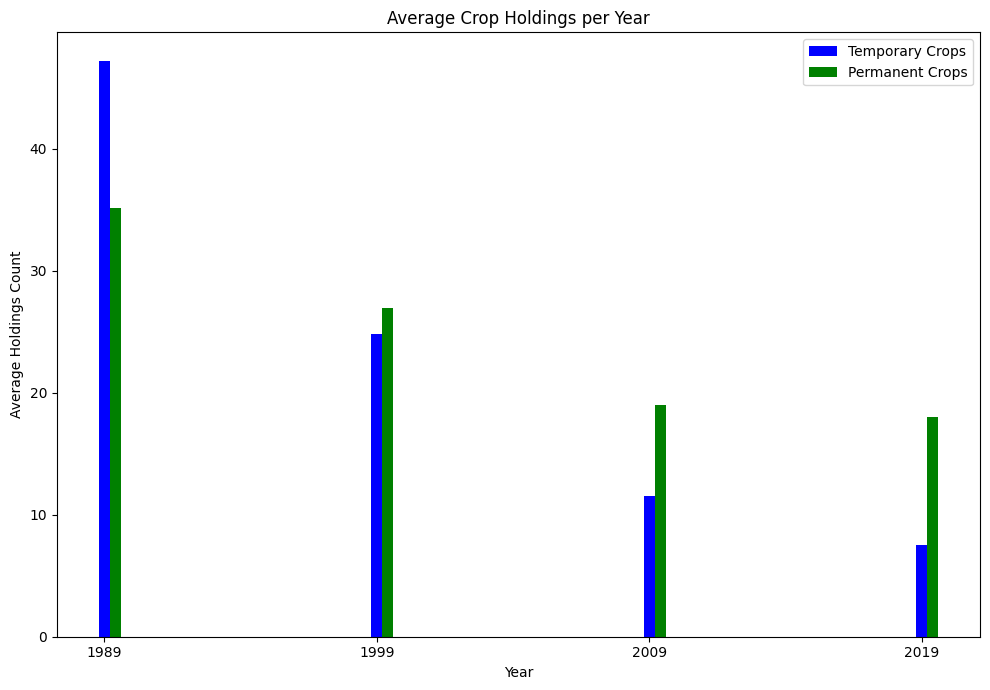

In [10]:
# Create a new DataFrame with only the specified columns
df_agriculture_selected = df_agriculture[columns_to_keep]

# Years of interest
years_of_interest = [1989, 1999, 2009, 2019]

# Filter data for the years of interest
filtered_data = df_agriculture_selected[df_agriculture_selected['temporary_crop_year'].isin(years_of_interest) |
                                         df_agriculture_selected['permanent_crop_year'].isin(years_of_interest)]

# Calculate average holdings per year for temporary crops
temp_crop_avg = filtered_data.groupby('temporary_crop_year')['temporary_crop_holdings'].mean()

# Calculate average holdings per year for permanent crops
perm_crop_avg = filtered_data.groupby('permanent_crop_year')['permanent_crop_holdings'].mean()

# Plotting the bar chart
plt.figure(figsize=(10, 7))

# Plot average holdings of temporary crops
plt.bar(temp_crop_avg.index, temp_crop_avg.values, width=0.4, align='center', label='Temporary Crops', color='b')

# Plot average holdings of permanent crops
plt.bar(perm_crop_avg.index + 0.4, perm_crop_avg.values, width=0.4, align='center', label='Permanent Crops', color='g')

plt.xlabel('Year')
plt.ylabel('Average Holdings Count')
plt.title('Average Crop Holdings per Year')
plt.xticks(years_of_interest)
plt.legend()
plt.tight_layout()
plt.show()

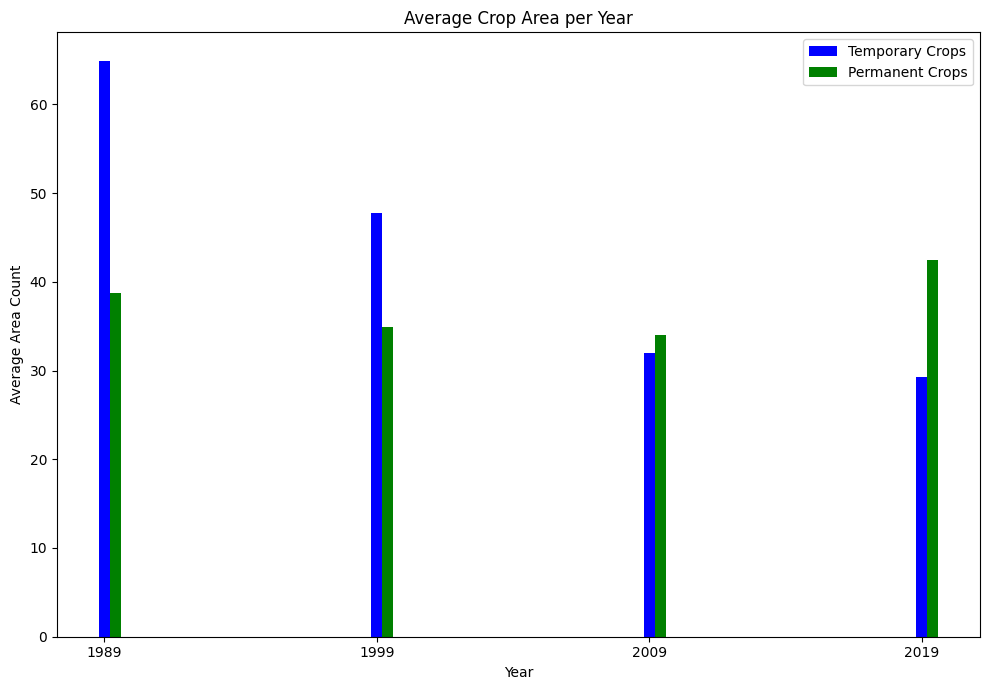

In [11]:
# Create a new DataFrame with only the specified columns
df_agriculture_selected = df_agriculture[columns_to_keep]

# Years of interest
years_of_interest = [1989, 1999, 2009, 2019]

# Filter data for the years of interest
filtered_data = df_agriculture_selected[df_agriculture_selected['temporary_crop_year'].isin(years_of_interest) |
                                         df_agriculture_selected['permanent_crop_year'].isin(years_of_interest)]

# Calculate average holdings per year for temporary crops
temp_crop_avg = filtered_data.groupby('temporary_crop_year')['temporary_crop_area'].mean()

# Calculate average holdings per year for permanent crops
perm_crop_avg = filtered_data.groupby('permanent_crop_year')['permanent_crop_area'].mean()

# Plotting the bar chart
plt.figure(figsize=(10, 7))

# Plot average holdings of temporary crops
plt.bar(temp_crop_avg.index, temp_crop_avg.values, width=0.4, align='center', label='Temporary Crops', color='b')

# Plot average holdings of permanent crops
plt.bar(perm_crop_avg.index + 0.4, perm_crop_avg.values, width=0.4, align='center', label='Permanent Crops', color='g')

plt.xlabel('Year')
plt.ylabel('Average Area Count')
plt.title('Average Crop Area per Year')
plt.xticks(years_of_interest)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
print(temp_crop_avg)

temporary_crop_year
1989    64.872241
1999    47.776371
2009    32.010167
2019    29.263949
Name: temporary_crop_area, dtype: float64


In [13]:
print(perm_crop_avg)

permanent_crop_year
1989    38.709775
1999    34.949093
2009    34.004759
2019    42.413899
Name: permanent_crop_area, dtype: float64


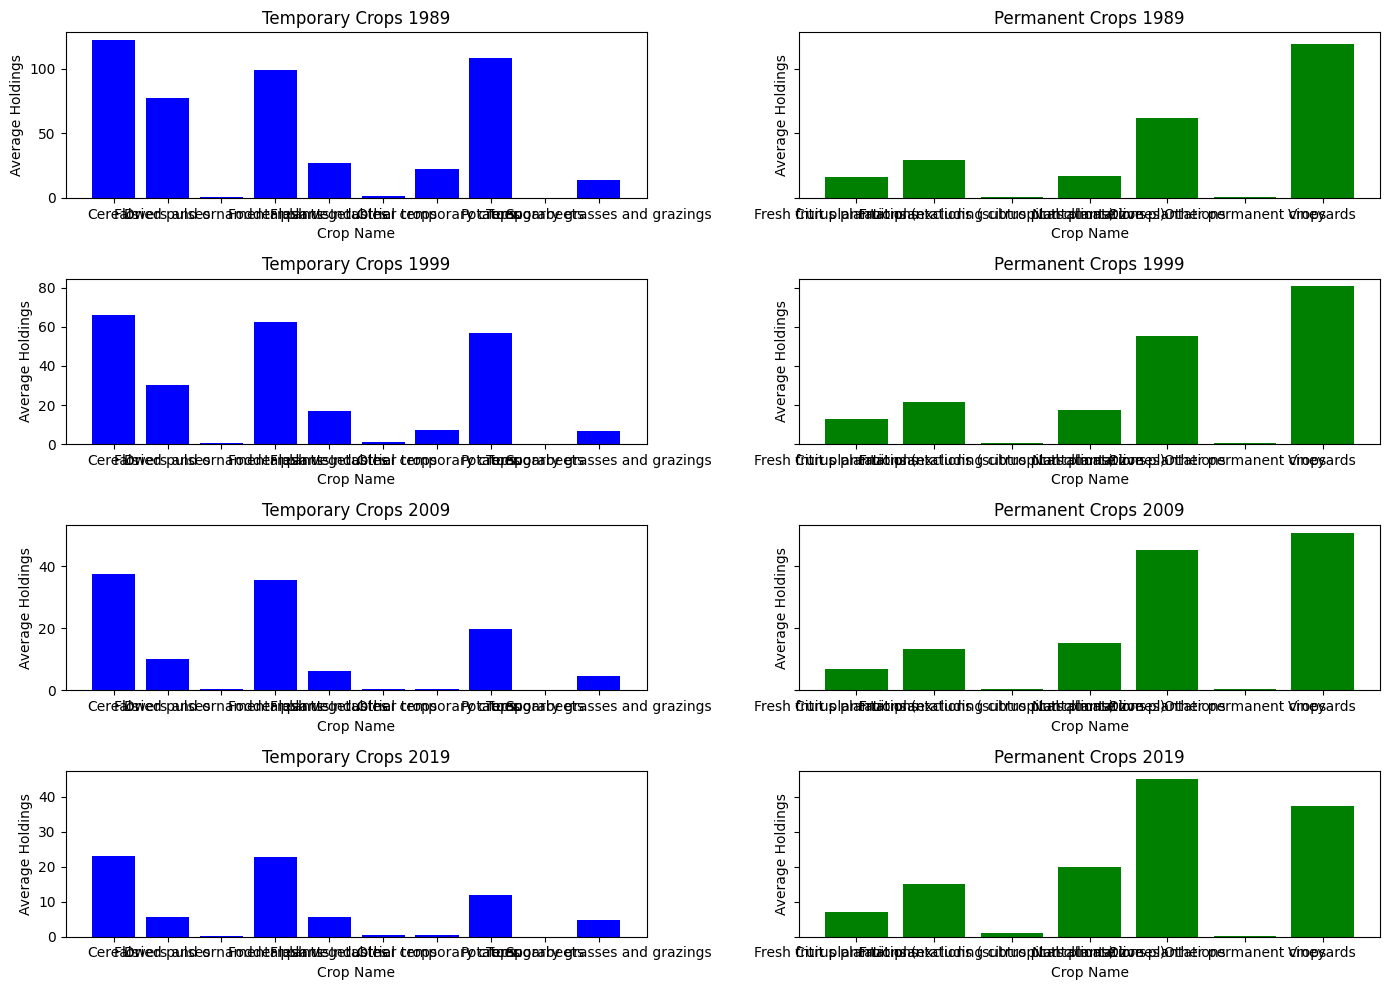

In [18]:
# Initialize empty lists to store results
temp_crop_avg_per_year = []
perm_crop_avg_per_year = []

# Calculate average holdings per crop name for each year for temporary crops
for year in years_of_interest:
    temp_crop_avg = df_agriculture_selected[df_agriculture_selected['temporary_crop_year'] == year].groupby('temporary_crop_name')['temporary_crop_holdings'].mean()
    temp_crop_avg_per_year.append(temp_crop_avg)

# Calculate average holdings per crop name for each year for permanent crops
for year in years_of_interest:
    perm_crop_avg = df_agriculture_selected[df_agriculture_selected['permanent_crop_year'] == year].groupby('permanent_crop_name')['permanent_crop_holdings'].mean()
    perm_crop_avg_per_year.append(perm_crop_avg)

# Plotting separate bar charts for each year
fig, axs = plt.subplots(len(years_of_interest), 2, figsize=(14, 10), sharey='row')

for i, year in enumerate(years_of_interest):
    # Plot average holdings of temporary crops for current year
    axs[i, 0].bar(temp_crop_avg_per_year[i].index, temp_crop_avg_per_year[i].values, color='b')
    axs[i, 0].set_title(f'Temporary Crops {year}')
    axs[i, 0].set_xlabel('Crop Name')
    axs[i, 0].set_ylabel('Average Holdings')

    # Plot average holdings of permanent crops for current year
    axs[i, 1].bar(perm_crop_avg_per_year[i].index, perm_crop_avg_per_year[i].values, color='g')
    axs[i, 1].set_title(f'Permanent Crops {year}')
    axs[i, 1].set_xlabel('Crop Name')
    axs[i, 1].set_ylabel('Average Holdings')

# Adding mplcursors for interactivity
mplcursors.cursor(hover=True)
plt.tight_layout()
plt.show()

In [19]:
print(temp_crop_avg_per_year)

[temporary_crop_name
Cereals                           122.185288
Dried pulses                       77.108952
Flowers and ornamental plants       0.620402
Fodder plants                      99.047536
Fresh vegetables                   26.729008
Industrial crops                    1.262318
Other temporary crops              22.599931
Potatoes                          108.409091
Sugarbeets                          0.011450
Temporary grasses and grazings     14.103053
Name: temporary_crop_holdings, dtype: float64, temporary_crop_name
Cereals                           66.069743
Dried pulses                      30.192922
Flowers and ornamental plants      0.605135
Fodder plants                     62.453158
Fresh vegetables                  16.863289
Industrial crops                   1.294240
Other temporary crops              7.169327
Potatoes                          56.682512
Sugarbeets                         0.171756
Temporary grasses and grazings     6.776891
Name: temporary_crop_h

In [20]:
print(perm_crop_avg_per_year)

[permanent_crop_name
Citrus plantations                                         16.557599
Fresh fruit plantations (excluding citrus plantations)     29.585704
Fruit plantations (subtropical climate zones)               0.369882
Nuts plantations                                           17.084316
Olive plantations                                          62.305344
Other permanent crops                                       0.967731
Vineyards                                                 119.490285
Name: permanent_crop_holdings, dtype: float64, permanent_crop_name
Citrus plantations                                        13.064192
Fresh fruit plantations (excluding citrus plantations)    21.330326
Fruit plantations (subtropical climate zones)              0.617974
Nuts plantations                                          17.257113
Olive plantations                                         55.175920
Other permanent crops                                      0.605135
Vineyards            

In [13]:
# Display the first few rows of the new DataFrame
print(df_agriculture_selected.head())


      NutsID         freguesia  temporary_crop_year  temporary_crop_holdings  \
0  111160101  Aboim das Choças                 2019                       19   
1  111160101  Aboim das Choças                 2019                        1   
2  111160101  Aboim das Choças                 2019                        0   
3  111160101  Aboim das Choças                 2019                        7   
4  111160101  Aboim das Choças                 2019                        7   

              temporary_crop_name  permanent_crop_year  \
0                         Cereals                 2019   
1                    Dried pulses                 2019   
2  Temporary grasses and grazings                 2019   
3                   Fodder plants                 2019   
4                        Potatoes                 2019   

   permanent_crop_holdings                                permanent_crop_name  
0                        0  Fresh fruit plantations (excluding citrus plan...  
1         

## Line plots showing changes in temporary and permanent crop holding counts and area over time ##

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


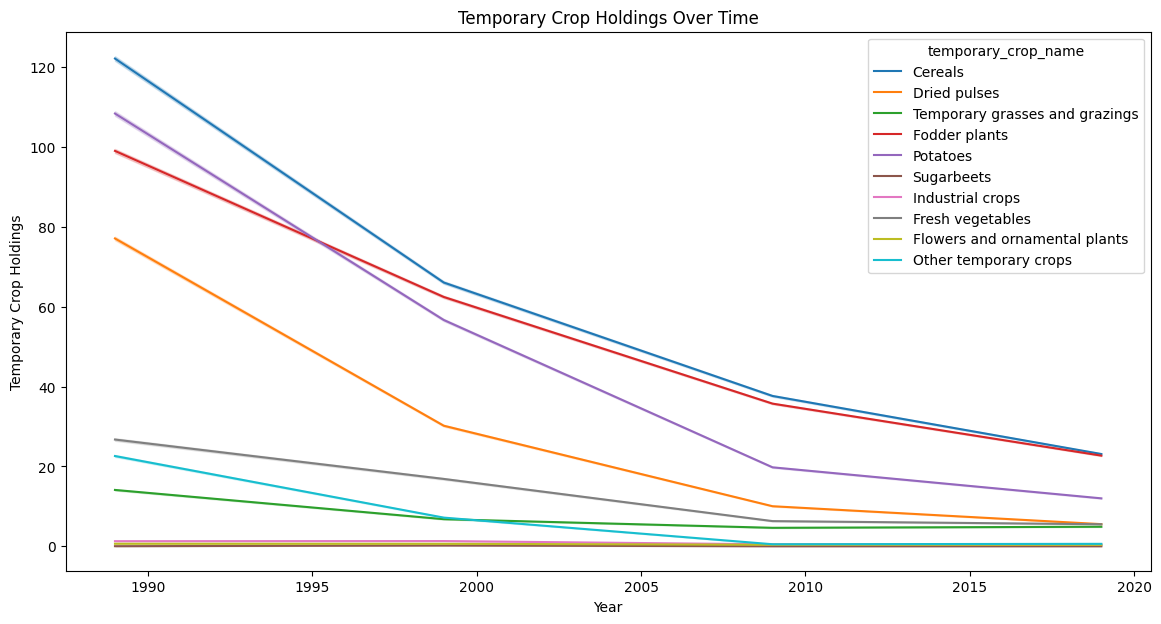

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


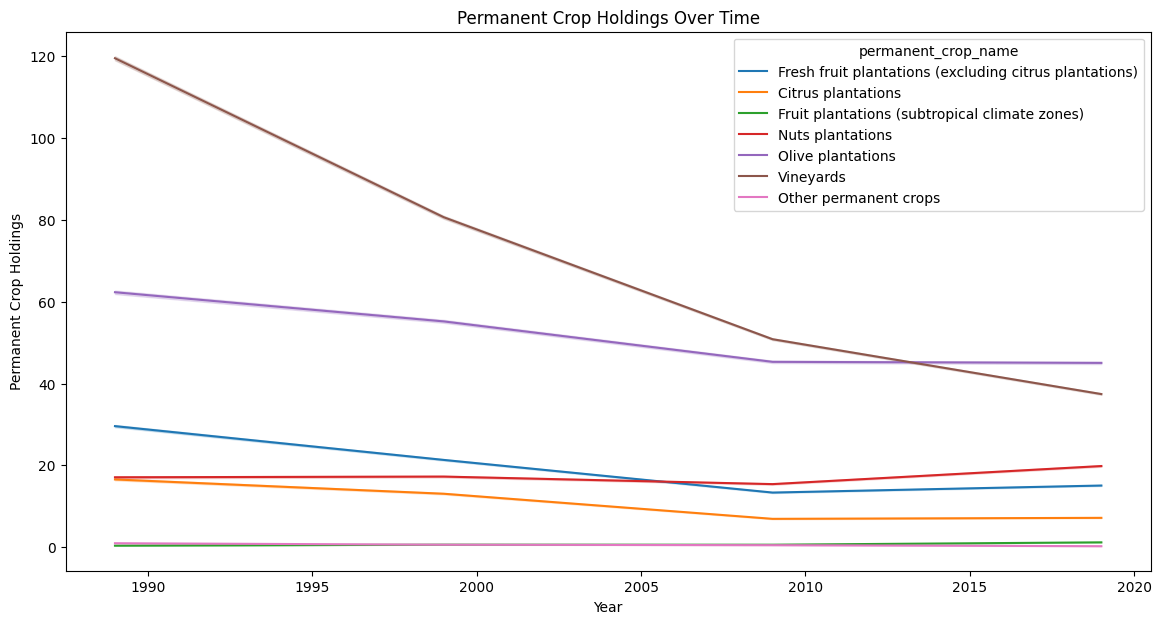

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Line plot for temporary crop holdings over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_agriculture_selected, x='temporary_crop_year', y='temporary_crop_holdings', hue='temporary_crop_name')
plt.title('Temporary Crop Holdings Over Time')
plt.xlabel('Year')
plt.ylabel('Temporary Crop Holdings')
plt.show()

# Line plot for permanent crop holdings over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_agriculture_selected, x='permanent_crop_year', y='permanent_crop_holdings', hue='permanent_crop_name')
plt.title('Permanent Crop Holdings Over Time')
plt.xlabel('Year')
plt.ylabel('Permanent Crop Holdings')
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categoric

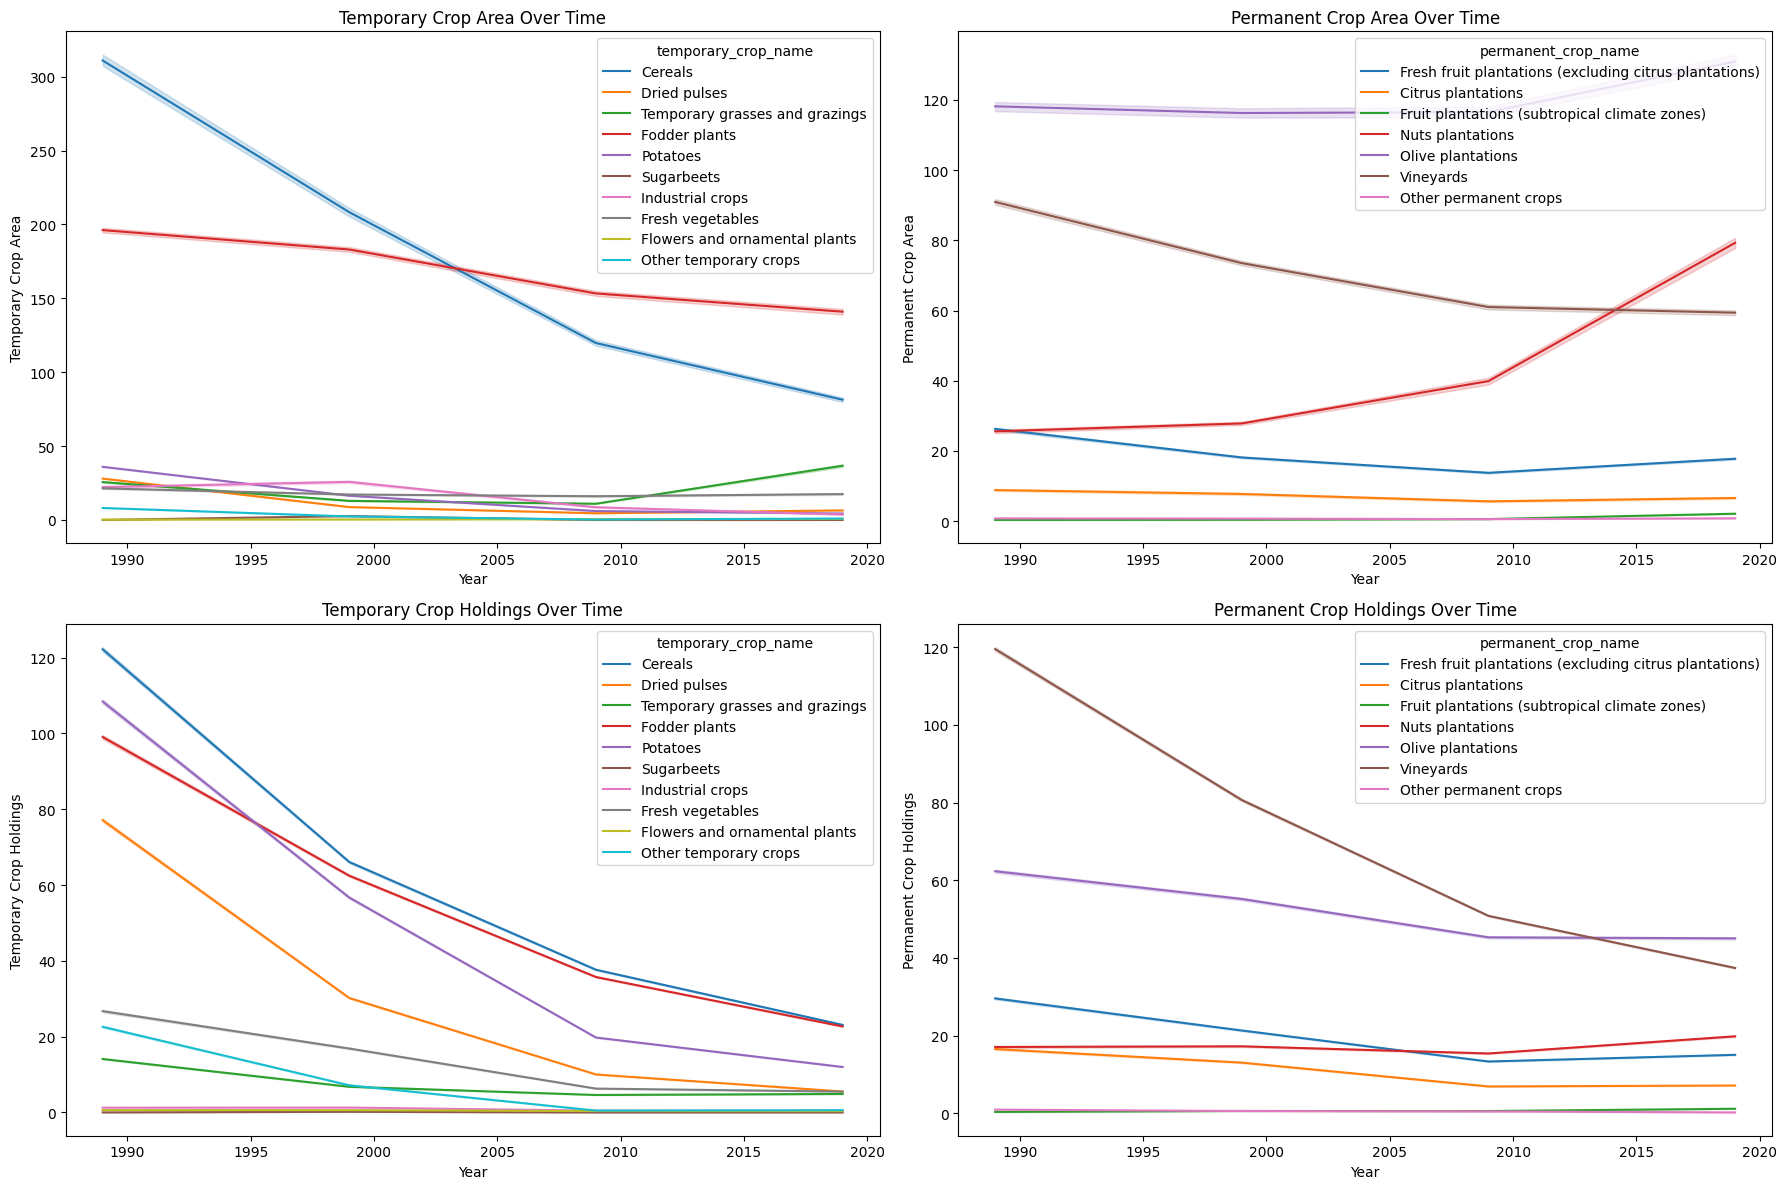

In [21]:
# Create a new DataFrame with only the specified columns
df_agriculture_selected = df_agriculture[columns_to_keep]

# Initialize the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Line plot for temporary crop area over time
sns.lineplot(ax=axs[0, 0], data=df_agriculture_selected, x='temporary_crop_year', y='temporary_crop_area', hue='temporary_crop_name')
axs[0, 0].set_title('Temporary Crop Area Over Time')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Temporary Crop Area')

# Line plot for permanent crop area over time
sns.lineplot(ax=axs[0, 1], data=df_agriculture_selected, x='permanent_crop_year', y='permanent_crop_area', hue='permanent_crop_name')
axs[0, 1].set_title('Permanent Crop Area Over Time')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Permanent Crop Area')

# Line plot for temporary crop holdings over time
sns.lineplot(ax=axs[1, 0], data=df_agriculture_selected, x='temporary_crop_year', y='temporary_crop_holdings', hue='temporary_crop_name')
axs[1, 0].set_title('Temporary Crop Holdings Over Time')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Temporary Crop Holdings')

# Line plot for permanent crop holdings over time
sns.lineplot(ax=axs[1, 1], data=df_agriculture_selected, x='permanent_crop_year', y='permanent_crop_holdings', hue='permanent_crop_name')
axs[1, 1].set_title('Permanent Crop Holdings Over Time')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Permanent Crop Holdings')

# Adjust layout
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


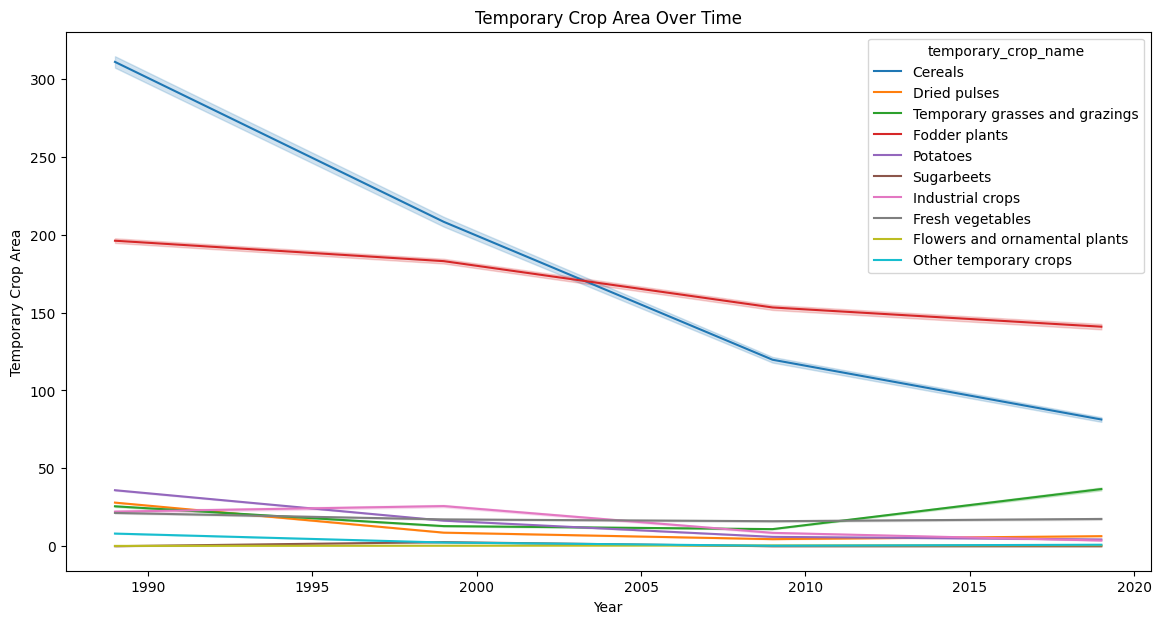

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


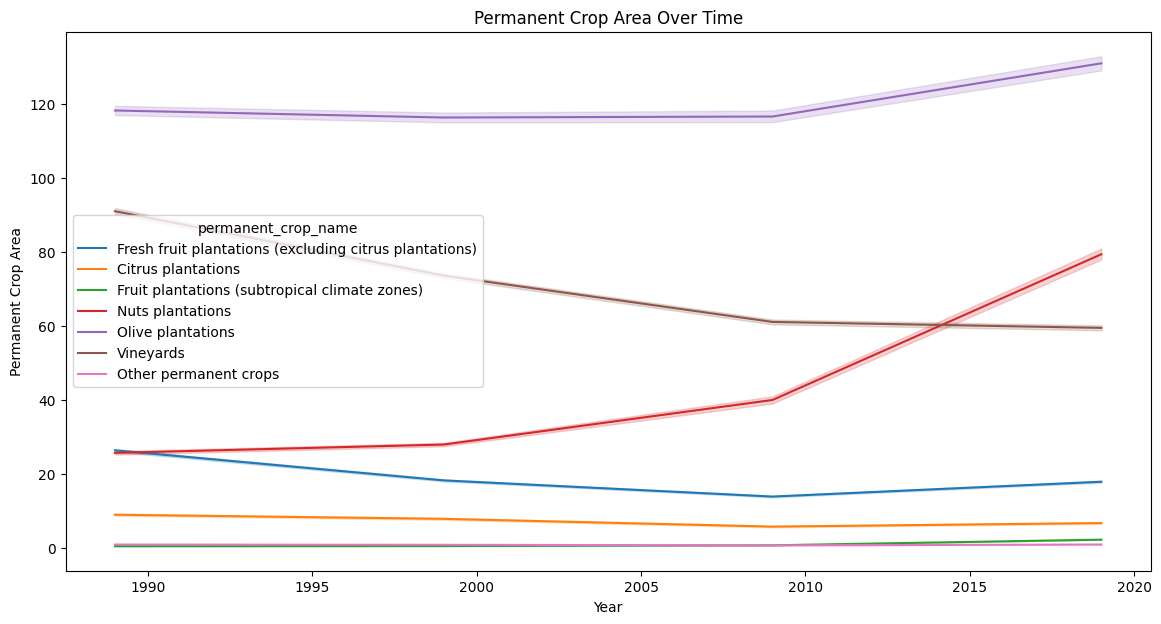

In [20]:
#line plot area

# Line plot for temporary crop area over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_agriculture_selected, x='temporary_crop_year', y='temporary_crop_area', hue='temporary_crop_name')
plt.title('Temporary Crop Area Over Time')
plt.xlabel('Year')
plt.ylabel('Temporary Crop Area')
plt.show()

# Line plot for permanent crop area over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_agriculture_selected, x='permanent_crop_year', y='permanent_crop_area', hue='permanent_crop_name')
plt.title('Permanent Crop Area Over Time')
plt.xlabel('Year')
plt.ylabel('Permanent Crop Area')
plt.show()

### Line plot showing both area and holding count ###

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_core.py:1225: FutureWarning: is_categoric

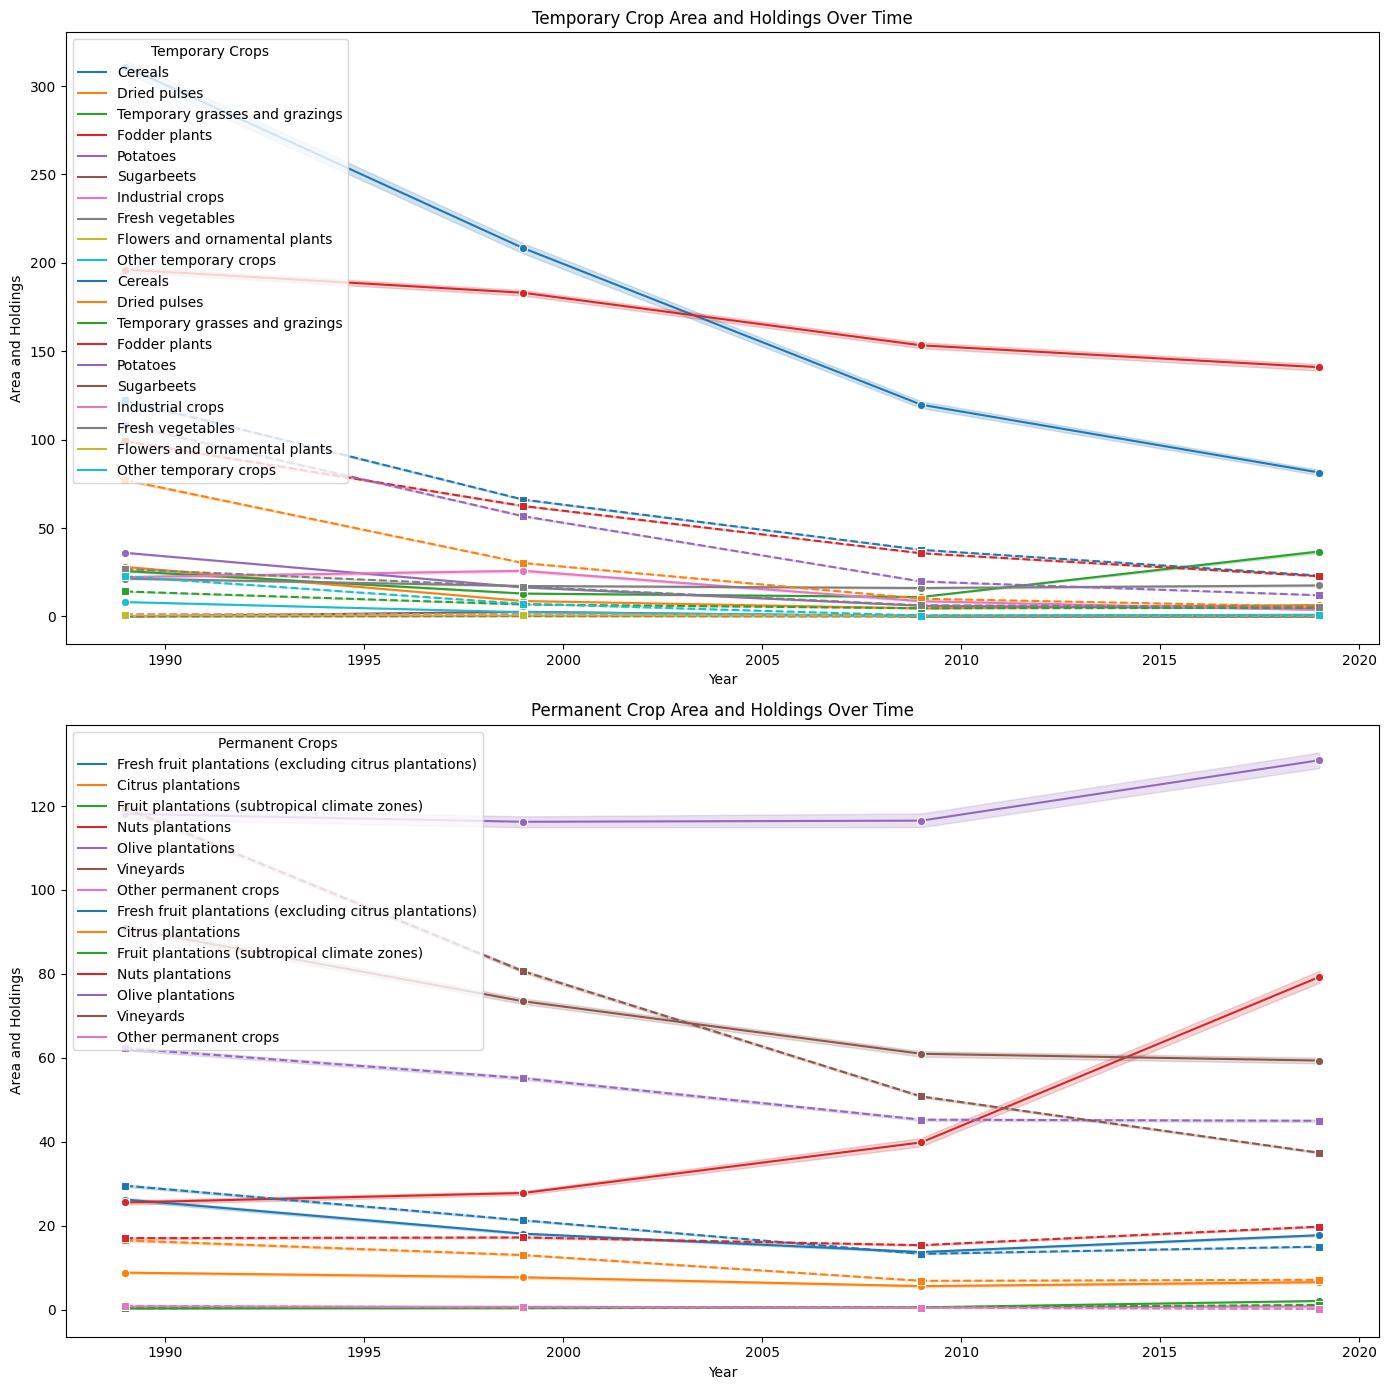

In [22]:
# Initialize the figure and axes
fig, axs = plt.subplots(2, 1, figsize=(14, 14))

# Line plot for temporary crop area and holdings over time
sns.lineplot(ax=axs[0], data=df_agriculture_selected, x='temporary_crop_year', y='temporary_crop_area', hue='temporary_crop_name', marker='o', linestyle='-')
sns.lineplot(ax=axs[0], data=df_agriculture_selected, x='temporary_crop_year', y='temporary_crop_holdings', hue='temporary_crop_name', marker='s', linestyle='--')
axs[0].set_title('Temporary Crop Area and Holdings Over Time')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Area and Holdings')
axs[0].legend(title='Temporary Crops', loc='upper left')

# Line plot for permanent crop area and holdings over time
sns.lineplot(ax=axs[1], data=df_agriculture_selected, x='permanent_crop_year', y='permanent_crop_area', hue='permanent_crop_name', marker='o', linestyle='-')
sns.lineplot(ax=axs[1], data=df_agriculture_selected, x='permanent_crop_year', y='permanent_crop_holdings', hue='permanent_crop_name', marker='s', linestyle='--')
axs[1].set_title('Permanent Crop Area and Holdings Over Time')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Area and Holdings')
axs[1].legend(title='Permanent Crops', loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()

### Percentages of crop holdings ###

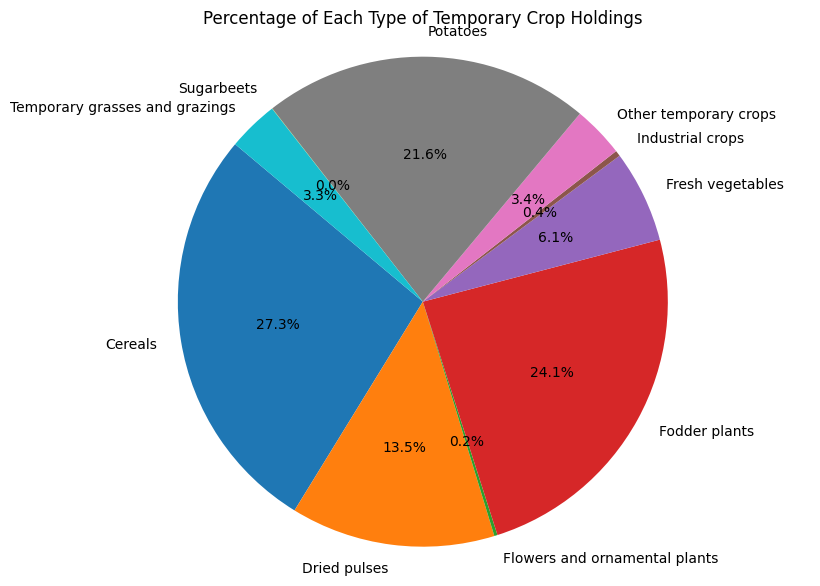

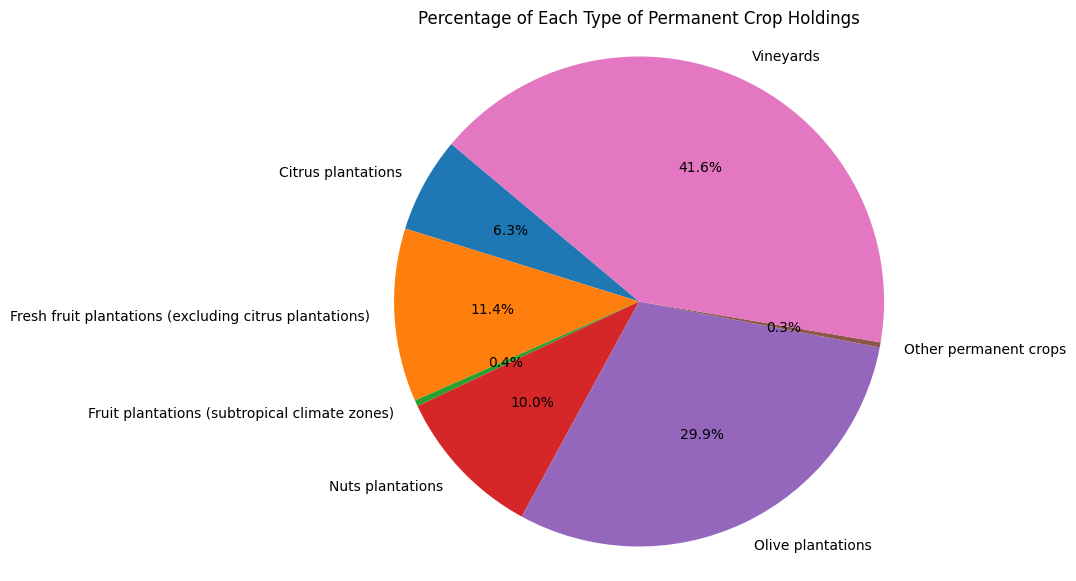

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by crop name and sum the holdings for temporary crops
temp_crop_holdings = df_agriculture_selected.groupby('temporary_crop_name')['temporary_crop_holdings'].sum()

# Calculate the percentage of each type of temporary crop holdings
temp_crop_percentages = temp_crop_holdings / temp_crop_holdings.sum() * 100

# Plot the pie chart for temporary crops
plt.figure(figsize=(10, 7))
plt.pie(temp_crop_percentages, labels=temp_crop_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Each Type of Temporary Crop Holdings')
plt.axis('equal')
plt.show()

# Group by crop name and sum the holdings for permanent crops
perm_crop_holdings = df_agriculture_selected.groupby('permanent_crop_name')['permanent_crop_holdings'].sum()

# Calculate the percentage of each type of permanent crop holdings
perm_crop_percentages = perm_crop_holdings / perm_crop_holdings.sum() * 100

# Plot the pie chart for permanent crops
plt.figure(figsize=(10, 7))
plt.pie(perm_crop_percentages, labels=perm_crop_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Each Type of Permanent Crop Holdings')
plt.axis('equal')
plt.show()


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_agriculture_selected is your DataFrame containing agriculture data

# Group by crop name and sum the holdings for temporary crops
temp_crop_holdings = df_agriculture_selected.groupby('temporary_crop_name')['temporary_crop_holdings'].sum()

# Plot the bar chart for temporary crops
plt.figure(figsize=(10, 7))
temp_crop_holdings.plot(kind='bar')
plt.title('Total Holdings of Each Type of Temporary Crop')
plt.xlabel('Temporary Crop')
plt.ylabel('Total Holdings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'df_agriculture_selected' is not defined

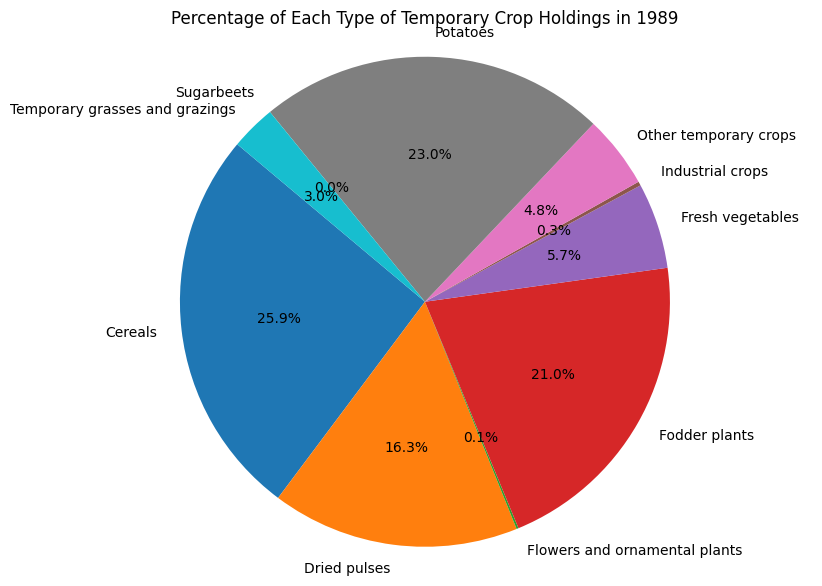

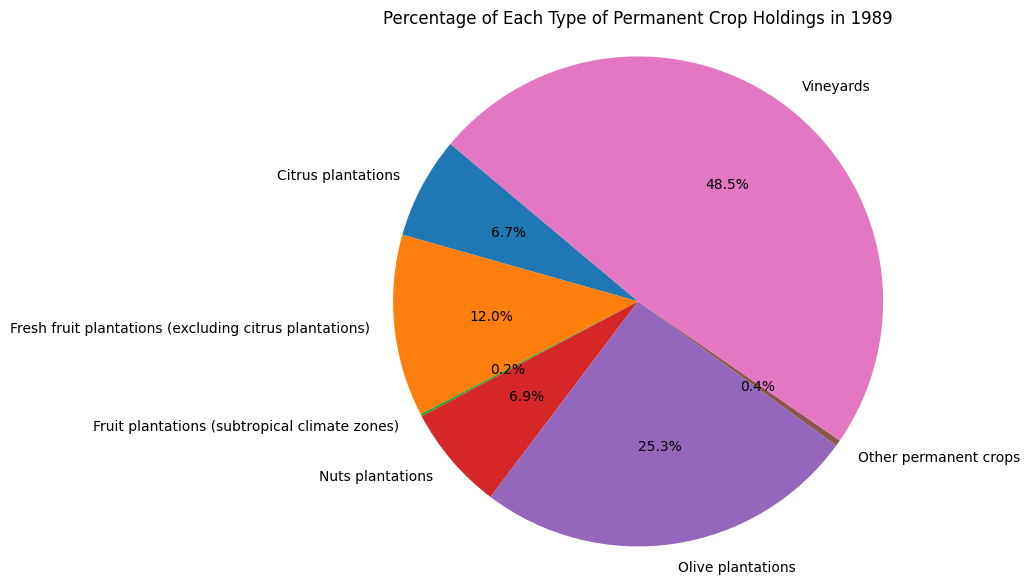

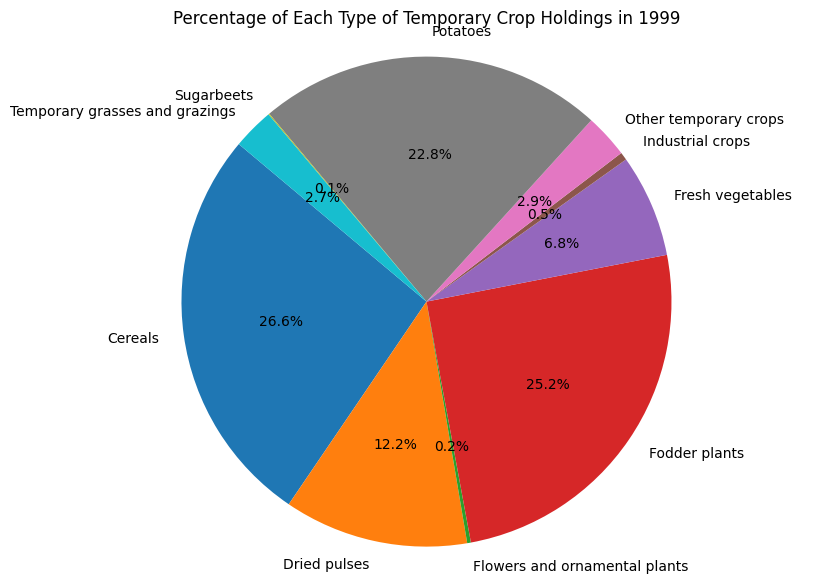

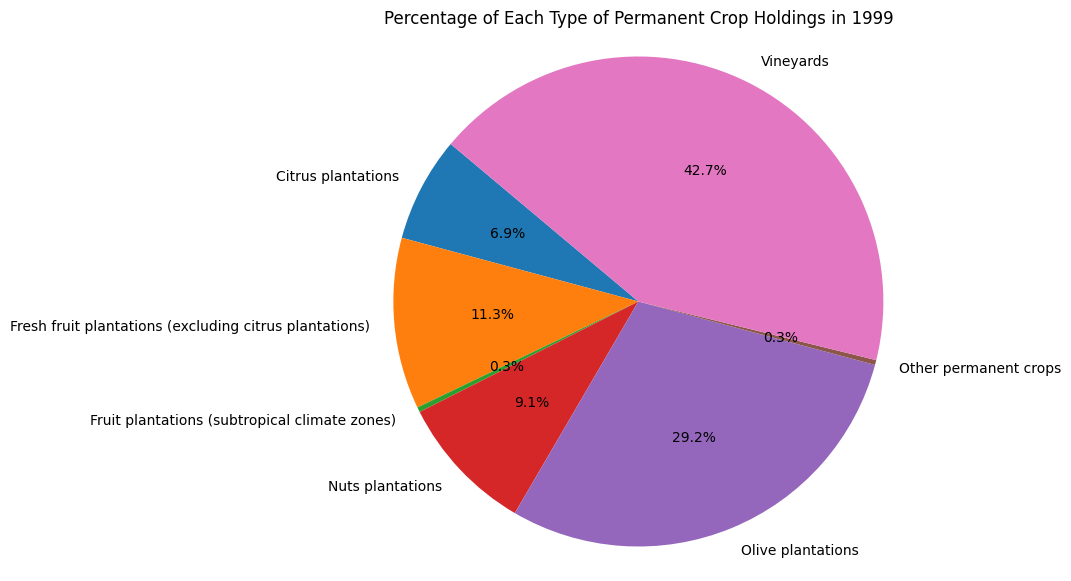

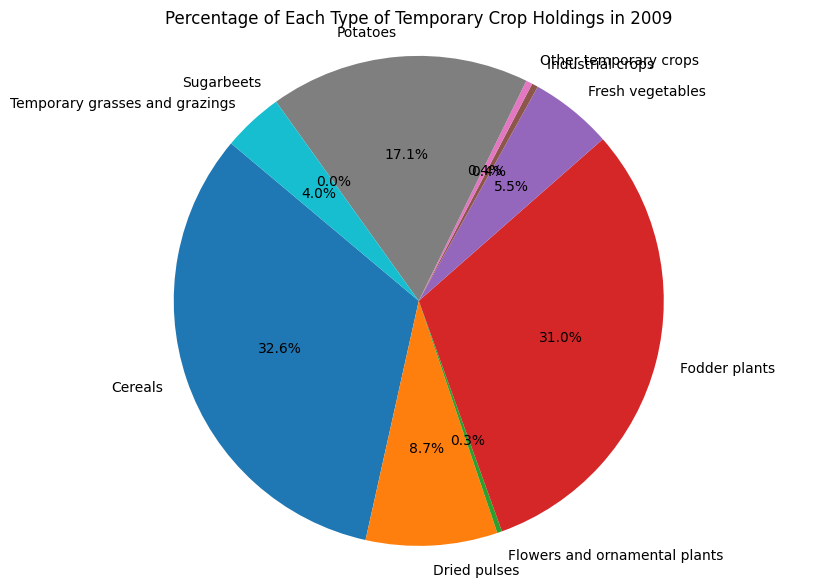

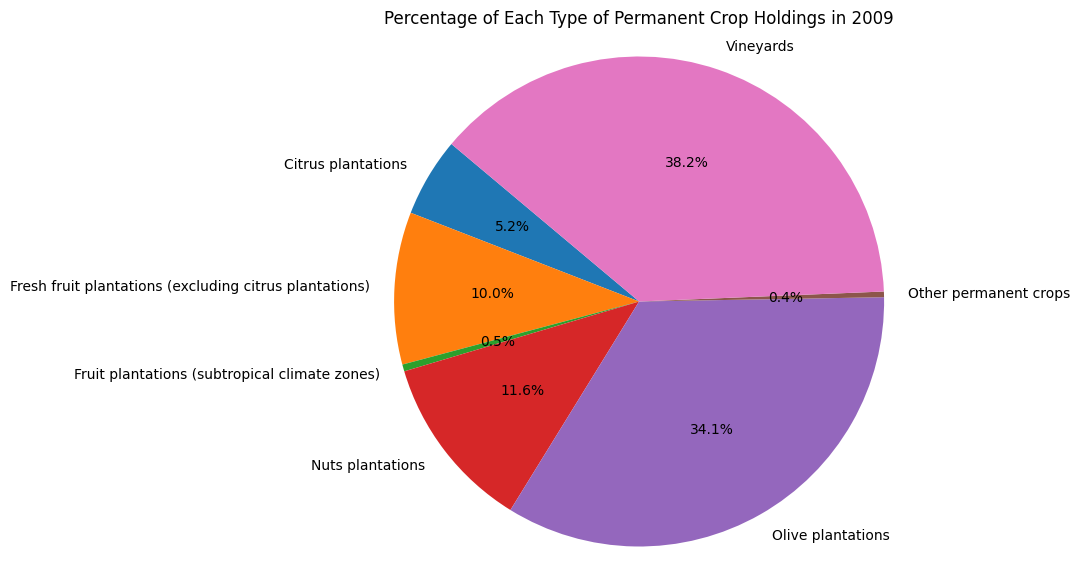

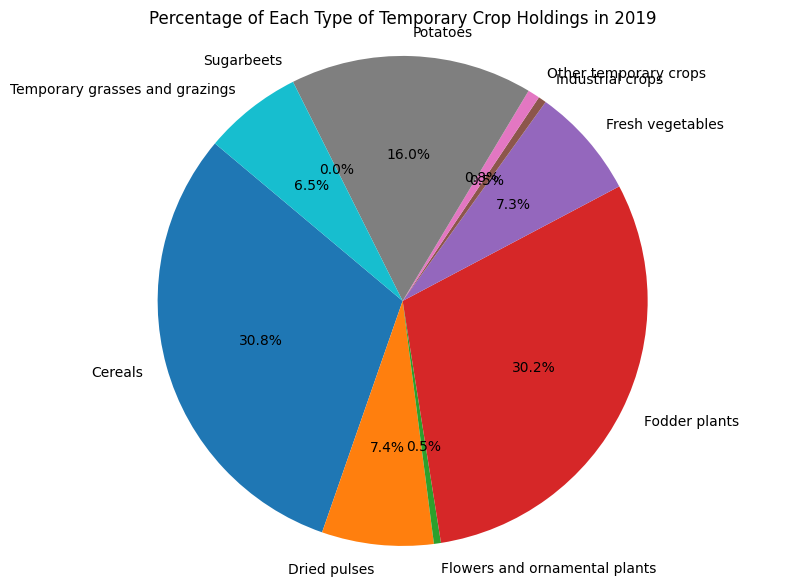

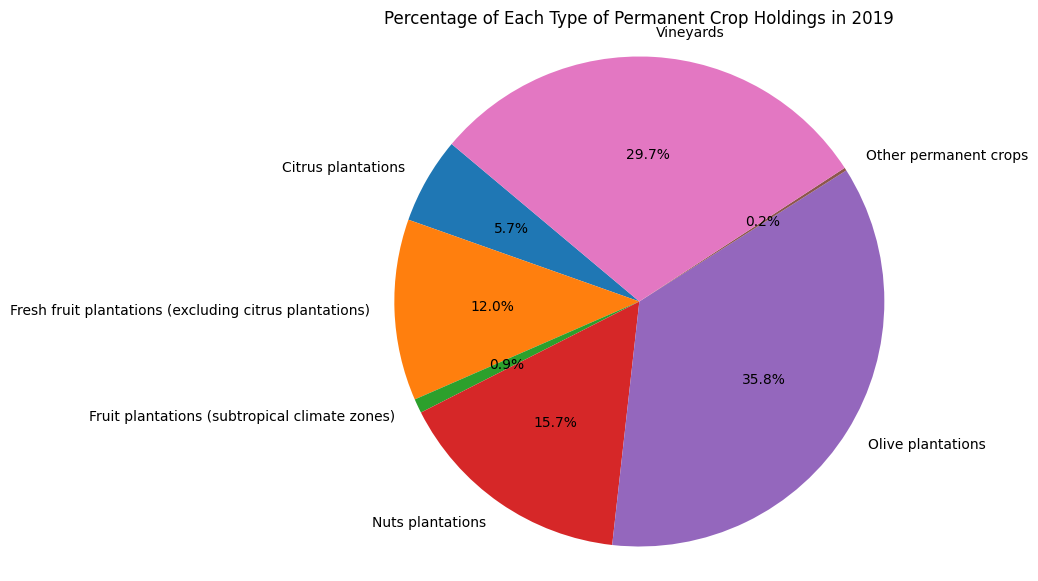

In [12]:
#separated by year
import pandas as pd
import matplotlib.pyplot as plt

years = [1989, 1999, 2009, 2019]

# Function to plot pie charts for temporary crops
def plot_temp_crop_pie(year):
    temp_crop_holdings_year = df_agriculture_selected[df_agriculture_selected['temporary_crop_year'] == year].groupby('temporary_crop_name')['temporary_crop_holdings'].sum()
    temp_crop_percentages_year = temp_crop_holdings_year / temp_crop_holdings_year.sum() * 100

    plt.figure(figsize=(10, 7))
    plt.pie(temp_crop_percentages_year, labels=temp_crop_percentages_year.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Percentage of Each Type of Temporary Crop Holdings in {year}')
    plt.axis('equal')
    plt.show()

# Function to plot pie charts for permanent crops
def plot_perm_crop_pie(year):
    perm_crop_holdings_year = df_agriculture_selected[df_agriculture_selected['permanent_crop_year'] == year].groupby('permanent_crop_name')['permanent_crop_holdings'].sum()
    perm_crop_percentages_year = perm_crop_holdings_year / perm_crop_holdings_year.sum() * 100

    plt.figure(figsize=(10, 7))
    plt.pie(perm_crop_percentages_year, labels=perm_crop_percentages_year.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Percentage of Each Type of Permanent Crop Holdings in {year}')
    plt.axis('equal')
    plt.show()

# Plot pie charts for each year
for year in years:
    plot_temp_crop_pie(year)
    plot_perm_crop_pie(year)


In [14]:
# Load the dataset
#file_path = '/Users/ines/greendatascience/AVCADo/final_project/output.csv' 
#data = pd.read_csv(file_path)

#print("Shape of the dataframe: ",data.shape)
#data.isna().sum()

In [15]:
data.head()

NameError: name 'data' is not defined

In [5]:
# drop null values

data.dropna(inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181440 entries, 11200 to 322559
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   NutsID                   181440 non-null  int64  
 1   DICOFRE_x                181440 non-null  int64  
 2   freguesia_x              181440 non-null  object 
 3   year                     181440 non-null  int64  
 4   education_level          181440 non-null  object 
 5   education_value          181440 non-null  int64  
 6   type_labour              181440 non-null  object 
 7   labour_value             181440 non-null  int64  
 8   production_value_eur     181440 non-null  float64
 9   production_area_ha       181440 non-null  float64
 10  DICOFRE_y                181440 non-null  int64  
 11  freguesia_y              181440 non-null  object 
 12  grassland_year           181440 non-null  int64  
 13  grassland_area           181440 non-null  int64  
 14  grass

In [7]:
data.describe()

,NutsID,DICOFRE_x,year,education_value,labour_value,production_value_eur,production_area_ha,DICOFRE_y,grassland_year,grassland_area,grassland_holdings,livestock_year,livestock_value,temporary_crop_year,temporary_crop_area,temporary_crop_holdings,permanent_crop_year,permanent_crop_area,permanent_crop_holdings
count,181440.0,181440.0,181440.000000,181440.000000,181440.000000,181440.000000,181440.000000,181440.0,181440.000000,181440.000000,181440.00000,181440.000000,181440.000000,181440.000000,181440.000000,181440.000000,181440.000000,181440.000000,181440.000000
mean,111160101.0,160101.0,2009.000000,25.555556,16.666667,123286.666667,1713.800000,160101.0,2004.000000,29.000000,10.00000,2004.000000,112.687500,2004.000000,7.500000,17.775000,2004.000000,2.250000,6.714286
std,0.0,0.0,8.164988,27.301321,19.810265,30503.145515,427.244878,0.0,11.180371,16.628335,6.04154,11.180371,215.305092,11.180371,14.769943,25.642309,11.180371,6.162258,18.187285
min,111160101.0,160101.0,1999.000000,4.000000,0.000000,101072.000000,1118.500000,160101.0,1989.000000,6.000000,2.00000,1989.000000,0.000000,1989.000000,0.000000,0.000000,1989.000000,0.000000,0.000000
25%,111160101.0,160101.0,1999.000000,6.000000,0.000000,101072.000000,1118.500000,160101.0,1996.500000,22.500000,5.75000,1996.500000,4.000000,1996.500000,0.000000,0.000000,1996.500000,0.000000,0.000000
50%,111160101.0,160101.0,2009.000000,7.000000,8.000000,102370.000000,1921.900000,160101.0,2004.000000,28.500000,10.00000,2004.000000,37.000000,2004.000000,0.000000,3.000000,2004.000000,0.000000,0.000000
75%,111160101.0,160101.0,2019.000000,57.000000,26.000000,166418.000000,2101.000000,160101.0,2011.500000,35.000000,14.25000,2011.500000,80.000000,2011.500000,8.250000,24.750000,2011.500000,0.000000,0.250000
max,111160101.0,160101.0,2019.000000,73.000000,63.000000,166418.000000,2101.000000,160101.0,2019.000000,53.000000,18.00000,2019.000000,925.000000,2019.000000,60.000000,80.000000,2019.000000,28.000000,84.000000


In [8]:
data.dtypes

NutsID                       int64
DICOFRE_x                    int64
freguesia_x                 object
year                         int64
education_level             object
education_value              int64
type_labour                 object
labour_value                 int64
production_value_eur       float64
production_area_ha         float64
DICOFRE_y                    int64
freguesia_y                 object
grassland_year               int64
grassland_area               int64
grassland_holdings           int64
animal_species              object
livestock_year               int64
livestock_value              int64
temporary_crop_year          int64
temporary_crop_area          int64
temporary_crop_holdings      int64
temporary_crop_name         object
permanent_crop_year          int64
permanent_crop_area          int64
permanent_crop_holdings      int64
permanent_crop_name         object
dtype: object